# Competition Kaggle

Comenzamos importando todas las lirerías que hacen falta

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.manifold import Isomap, TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
import seaborn as sns


In [2]:
cnx = mysql.connector.connect(user='root', password='example',
                              host='host.docker.internal', port=3306)
cnx.close()

Funciones a utilizar

In [3]:
def printCountValues(trainTmp):
    for col in trainTmp.drop('Id', axis = 1):
        print(col)
        print(trainTmp[col].value_counts())
        print('--------------------')
        

def printBarrasApiladas(dfApilada , X, normalize=True):
    dfApilada = dfApilada[['target', X]]
    sizeDf = dfApilada.shape[0]
    dfApiladaDummy = pd.get_dummies(dfApilada['target'], prefix="", prefix_sep="")
    dfApilada = pd.concat([dfApilada,dfApiladaDummy],1)
    dfApilada['count'] = 1
    dfApilada = dfApilada.groupby(X, dropna=False).sum().reset_index()
    if normalize == False:
        dfApilada['count'] = 1
    columnNa = -1
    if dfApilada[X].dtypes == 'object':
        dfApilada["sort"] = dfApilada["1"]/dfApilada["count"]
        dfApilada = dfApilada.sort_values('sort')   
        dfApilada = dfApilada.drop(["sort"], axis = 1)
        columnNa = "Nan"
    dfApilada[X] = dfApilada[X].fillna(columnNa)
    dfApiladaSum = np.zeros([dfApilada.shape[0],])
    plt.figure(figsize=(15, 3))
    for i in dfApilada.drop([X, 'target', 'count'], axis = 1):
        plt.bar(dfApilada[X], dfApilada[i]/dfApilada['count'], label = i, bottom = dfApiladaSum)
        dfApiladaSum = dfApiladaSum + np.array(dfApilada[i]/dfApilada['count'])
    plt.title(X)
    plt.legend()
    plt.xticks(rotation=45)
    
def filter_columns(dfTmp, filter_column):
    list_columns = [column for column in dfTmp.columns if filter_column in column]
    return list_columns

def notNullRelation(dfTmp , listColumn):
    dfTmp = dfTmp[listColumn].notna().astype(int)
    num = 1
    dfTmp['sum'] = 0
    for item in dfTmp.drop('sum', axis = 1):
        print(item)
        print(num)
        dfTmp[item] = dfTmp[item]*num
        dfTmp['sum'] = dfTmp['sum'] + dfTmp[item]
        num = num*10
    dfTmp = dfTmp.reset_index()
    print('---------------')
    print(dfTmp['sum'].value_counts())

def dropNullColumns(dfInput):
    dfWithOutNulls = dfInput.isna().sum()
    dfWithOutNulls = dfInput[dfWithOutNulls[dfWithOutNulls == 0].index]
    return dfWithOutNulls

def roc_auc_score_by_threshold(clf, target):
    if True:
        roc_auc_scores = []
        for threshold in np.arange(0.01, 1, 0.01):
            predictions = probabilities >= threshold
            roc_auc_scores.append((threshold, roc_auc_score(target, predictions)))
        max_roc_auc_threshold = sorted(roc_auc_scores, key=lambda x:x[1], reverse=True)[0][0]
        predictions = probabilities >= max_roc_auc_threshold
    else:
        predictions = probabilities
    #print(f'optimum threshold found: {max_roc_auc_threshold}')
    #print(f'roc value: {roc_auc_score(target, predictions)}')

    
def comb_dicc(param_grid):
    listComb = []
    for comb in itertools.product(*[param_grid[c] for c in param_grid]):
        i = 0
        param_grid_new = {}
        for item in param_grid:
            param_grid_new[item] = comb[i]
            i+=1
        listComb.append(param_grid_new)
    return listComb
    
def show_metrics(clf, X_val, target):
    precision, recall, f1, _ = precision_recall_fscore_support(
    y_true=target,
    y_pred=clf.predict(X_val)
    )
    roc_auc = roc_auc_score(target, clf.predict_proba(X_val)[:,1])

    metrics = {
        "precision": precision[1],
        "recall": recall[1],
        "f1": f1[1],
        "roc_auc": roc_auc,
    }
    print(f'Confusion matrix: \n{confusion_matrix(target, clf.predict(X_val))}')
    print(metrics)
    
def group_column(df_tmp, column_group, n_clusters = 0):
    df_tmp = df_tmp[["target", column_group]]
    df_tmp = df_tmp.groupby(column_group).target.agg(['mean', 'sum', 'count'])
    if n_clusters == 0:
        n_clusters = df_tmp.index.size
    model = KMeans(n_clusters = n_clusters)
    model.fit(df_tmp['mean'].values.reshape(-1, 1))
    dicc_labels = dict(zip(model.cluster_centers_[:,0], list(range(n_clusters))))
    labels_sort = dict(sorted(dicc_labels.items(), key=lambda item: item[0])).values()
    dicc_sort = dict(zip(labels_sort, list(range(n_clusters))))
    df_tmp['group'] = np.vectorize(dicc_sort.get)(model.labels_)
    dicc_nivel_instruccion = dict(zip(df_tmp.index, df_tmp['group']))
    df[column_group] = df[column_group].map(dicc_nivel_instruccion)
    return df

Creamos una copia original de la lectura del archivo para no tener que volverla a leer

In [4]:
dfOrig = pd.read_csv('competitionKschool/Train.csv', sep=',', encoding='latin-1')

In [5]:
df = dfOrig.copy()
dfOrig.columns

Index(['Id', 'target', 'calificacion_mes00', 'calificacion_mes01',
       'calificacion_mes02', 'calificacion_mes03', 'calificacion_mes04',
       'calificacion_mes05', 'canal', 'cant_ent_deuda_consu_mes00',
       'cant_ent_deuda_consu_mes01', 'cant_ent_deuda_consu_mes02',
       'cant_ent_deuda_consu_mes03', 'cant_ent_deuda_consu_mes04',
       'cant_ent_deuda_consu_mes05', 'cant_ent_deuda_hipot_mes00',
       'cant_ent_deuda_hipot_mes01', 'cant_ent_deuda_hipot_mes02',
       'cant_ent_deuda_hipot_mes03', 'cant_ent_deuda_hipot_mes04',
       'cant_ent_deuda_hipot_mes05', 'cant_prot_no_aclarados_soles',
       'cantidad_doc_morosos', 'clase_canal', 'codigo_rubro_actividad',
       'cond_domicilio_sunat', 'deuda_dir_vig_consu_mes00',
       'deuda_dir_vig_consu_mes01', 'deuda_dir_vig_consu_mes02',
       'deuda_dir_vig_consu_mes03', 'deuda_dir_vig_consu_mes04',
       'deuda_dir_vig_consu_mes05', 'direccion_eval', 'edad',
       'esta_reportado_mes00', 'esta_reportado_mes01', 'esta_rep

<ipython-input-3-cbcf84f7c71e>:12: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  dfApilada = pd.concat([dfApilada,dfApiladaDummy],1)


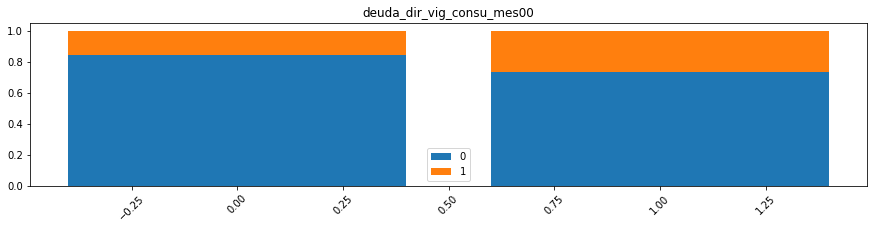

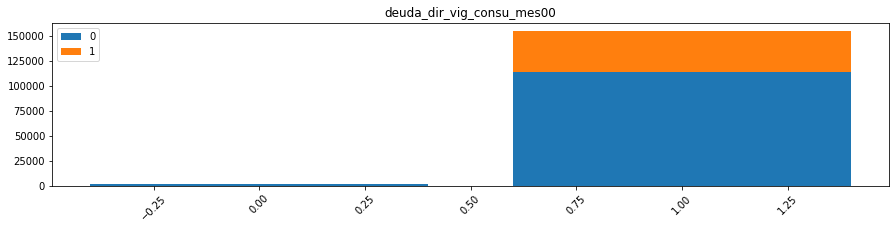

In [6]:
df_tmp = df[["target", 'deuda_dir_vig_consu_mes00']][df['deuda_dir_vig_consu_mes00']<50000000]

df_tmp['deuda_dir_vig_consu_mes00'] = df_tmp['deuda_dir_vig_consu_mes00'].fillna(0)
df_tmp['deuda_dir_vig_consu_mes00'] = df_tmp['deuda_dir_vig_consu_mes00'].map(lambda x: 0 if x < 15 else 1)
#df_tmp['deuda_dir_vig_consu_mes00'] = (df_tmp['deuda_dir_vig_consu_mes00']/10).astype(int)
printBarrasApiladas(df_tmp , "deuda_dir_vig_consu_mes00", True)
printBarrasApiladas(df_tmp , "deuda_dir_vig_consu_mes00", False)

In [20]:
rubros = df['monto_doc_morosos_soles'].value_counts()
for rubro in rubros:
    print(rubro)

343832
260
257
234
165
156
155
153
119
113
103
96
96
95
94
93
89
88
84
76
74
68
60
60
59
58
58
55
55
54
54
52
52
51
51
49
49
49
48
47
47
47
46
46
45
44
44
44
43
43
43
43
43
43
42
41
40
39
39
39
39
39
38
38
38
37
37
37
36
36
36
36
36
35
35
35
35
35
34
34
34
33
33
33
32
32
32
32
31
31
31
31
30
30
30
29
29
29
29
29
29
29
29
29
29
29
29
28
28
27
27
26
26
26
26
26
26
26
26
26
26
26
25
25
25
25
25
25
25
24
24
24
24
24
24
24
24
23
23
23
23
23
22
22
22
22
22
22
22
22
22
22
22
21
21
21
21
21
21
21
21
21
21
21
21
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [23]:
columns_not_null = df.isna().sum()[df.isna().sum() == 0].index
print(columns_not_null)
printCountValues(df[columns_not_null])

Index(['Id', 'target', 'calificacion_mes00', 'calificacion_mes01',
       'calificacion_mes02', 'calificacion_mes03', 'calificacion_mes04',
       'calificacion_mes05', 'canal', 'cantidad_doc_morosos', 'clase_canal',
       'cond_domicilio_sunat', 'direccion_eval', 'esta_reportado_mes00',
       'esta_reportado_mes01', 'esta_reportado_mes02', 'esta_reportado_mes03',
       'esta_reportado_mes04', 'esta_reportado_mes05', 'estado_civil',
       'ind_bancarizacion_ult10m', 'ind_morosidad', 'info_directorio_sunat',
       'nivel_instruccion', 'rango_ingresos_2'],
      dtype='object')
target
0    322262
1    165815
Name: target, dtype: int64
--------------------
calificacion_mes00
No Reportado        236335
Normal              158734
Perdida              46843
Sin Calificación     20754
CPP                  11925
Deficiente            5629
Dudoso                5396
No identificado       2461
Name: calificacion_mes00, dtype: int64
--------------------
calificacion_mes01
No Reportado       

<ipython-input-3-cbcf84f7c71e>:12: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  dfApilada = pd.concat([dfApilada,dfApiladaDummy],1)


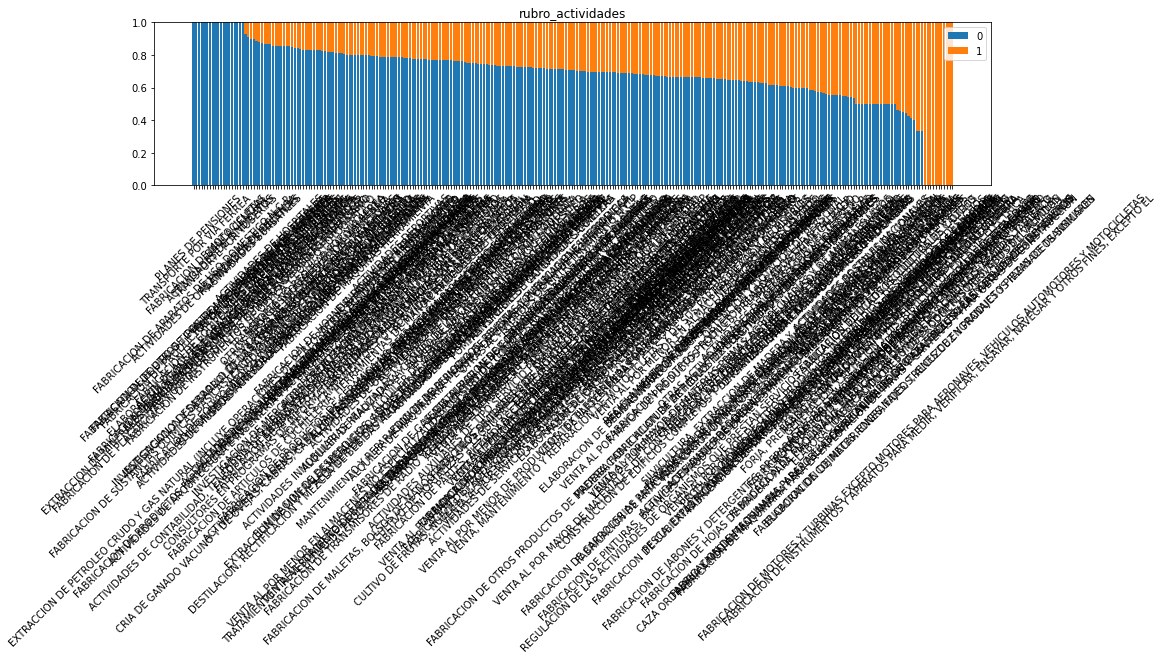

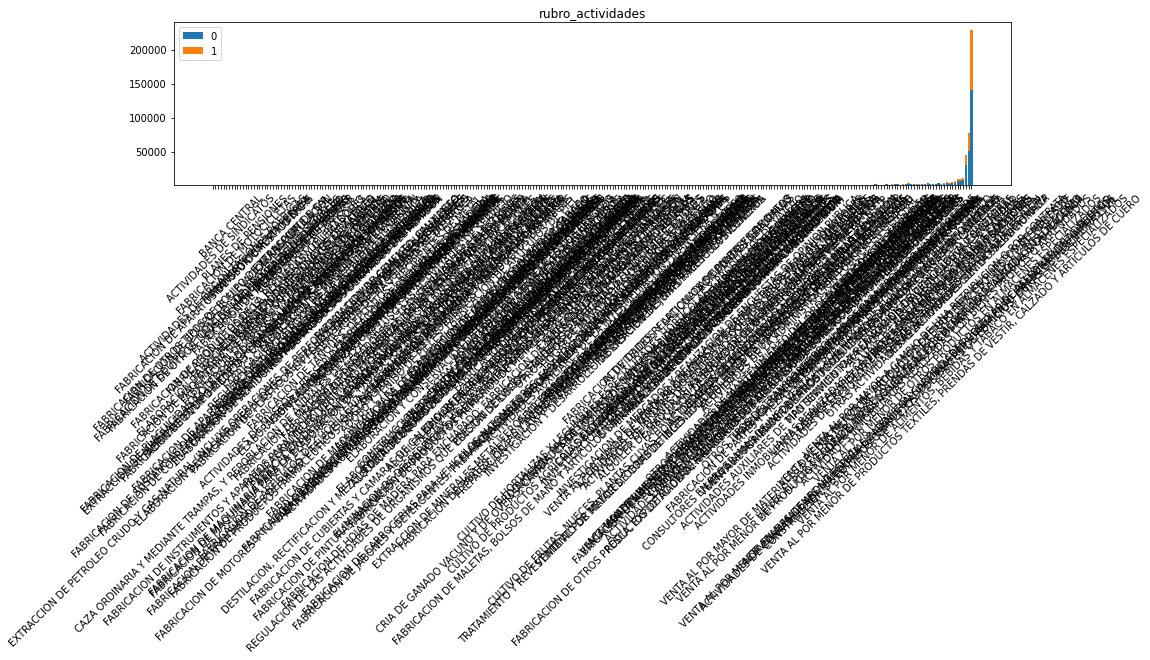

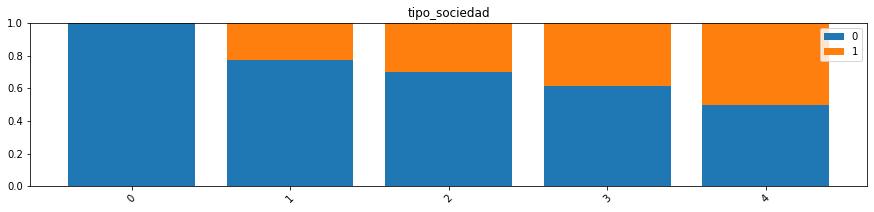

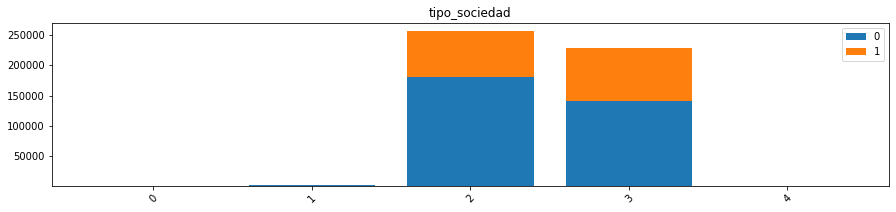

In [25]:
printBarrasApiladas(df , "rubro_actividades", True)
printBarrasApiladas(df , "rubro_actividades", False)
printBarrasApiladas(df , "tipo_sociedad", True)
printBarrasApiladas(df , "tipo_sociedad", False)

In [44]:
df.isna().sum()[df.isna().sum() > 0]

cant_ent_deuda_consu_mes00      238796
cant_ent_deuda_consu_mes01      242562
cant_ent_deuda_consu_mes02      245575
cant_ent_deuda_consu_mes03      248653
cant_ent_deuda_consu_mes04      251079
cant_ent_deuda_consu_mes05      254027
cant_ent_deuda_hipot_mes00      238796
cant_ent_deuda_hipot_mes01      242562
cant_ent_deuda_hipot_mes02      245575
cant_ent_deuda_hipot_mes03      248653
cant_ent_deuda_hipot_mes04      251079
cant_ent_deuda_hipot_mes05      254027
cant_prot_no_aclarados_soles      2461
codigo_rubro_actividad          228651
deuda_dir_vig_consu_mes00       330583
deuda_dir_vig_consu_mes01       333531
deuda_dir_vig_consu_mes02       336109
deuda_dir_vig_consu_mes03       338259
deuda_dir_vig_consu_mes04       340243
deuda_dir_vig_consu_mes05       342107
edad                             21298
monto_doc_morosos_soles           2461
risk_predictor_2                  7771
rubro_actividades               228651
situacion_contribuyente         228486
tipo_sociedad            

### Primera lectura

Realizamos los primeros mapeos de los campos

In [7]:
df = dfOrig.copy()
columns_deuda_dir_vig_consu = filter_columns(df, 'deuda_dir_vig_consu_mes')
for column in columns_deuda_dir_vig_consu:
    df[column] = df[column].fillna(0)
    df[column] = df[column].map(lambda x: 0 if x < 15 else 1)

## monto_doc_morosos_soles
df['monto_doc_morosos_soles'] = df['monto_doc_morosos_soles'].fillna(0)
df['monto_doc_morosos_soles'] = df['monto_doc_morosos_soles'].map(lambda x: 0 if x < 6 else 1)

## Diccionario direccion_eval
dicc_direccion_eval = {'mala':0, 'regular':1, 'normal':2, 'buena':3}
df['direccion_eval'] = df['direccion_eval'].map(dicc_direccion_eval)

## dicc_rango_ingresos_2
dicc_rango_ingresos_2 = {'No identificado' : -1, 'Sin ingreso' : 1000, '< 450' : 450, '<450' : 450, '[450 - 600>' : 600, '[450-600>' : 600, '[600 - 1,000>' : 1000, '[600-1,000>' : 1000, '[1,000 - 1,300>' : 1300, '[1,000-1,300>' : 1300, '[1,300 - 2,000>' : 2000, '[1,300-2,000>' : 2000, '[2,000 - 3,500>' : 3500, '[2,000-3,500>' : 3500, '[3,500 - 6,000>' : 6000, '[3,500-6,000>' : 6000, '[6,000 - 10,000>' : 10000, '[6,000-10,000>' : 10000, '>=10,000' : 15000}
#dicc_rango_ingresos_2 = {'No identificado' : -1, 'Sin ingreso' : 6, '< 450' : 0, '<450' : 1, '[450 - 600>' : 2, '[450-600>' : 3, '[600 - 1,000>' : 4, '[600-1,000>' : 5, '[1,000 - 1,300>' : 6, '[1,000-1,300>' : 7, '[1,300 - 2,000>' : 8, '[1,300-2,000>' : 9, '[2,000 - 3,500>' : 10, '[2,000-3,500>' : 11, '[3,500 - 6,000>' : 12, '[3,500-6,000>' : 13, '[6,000 - 10,000>' : 14, '[6,000-10,000>' : 15, '>=10,000' : 16}
df['rango_ingresos_2'] = df['rango_ingresos_2'].map(dicc_rango_ingresos_2)
df['rango_ingresos_2_No_id'] = (df['rango_ingresos_2'] == -1).astype(int)
df['rango_ingresos_2'] = df['rango_ingresos_2'].map(lambda x: x if x >-1 else 1300)
df['rango_ingresos_2_No_id'] = (df['rango_ingresos_2'] == -1).astype(int)

## dicc_calificacion
dicc_calificacion = {'Sin Calificación' : 1,'No identificado' : 1, 'Normal' : 2, 'No Reportado' : 3, 'CPP' : 3, 'Deficiente' : 4, 'Dudoso' : 5, 'Perdida' :6}
columns_calificacion = filter_columns(df, 'calificacion_mes')
for column in columns_calificacion:
    df[column] = df[column].map(dicc_calificacion)

## dicc_reportado
dicc_reportado = {'No identificado' : 0,'Si' : 1, 'No' : 2}
columns_reportado = filter_columns(df, 'esta_reportado_mes')
for column in columns_reportado:
    df[column] = df[column].map(dicc_reportado)

## cantidad_doc_morosos
df['cantidad_doc_morosos'] = df['cantidad_doc_morosos'].map(lambda x: x if x != 'No identificado' else 0)
df['cantidad_doc_morosos'] = df['cantidad_doc_morosos'].astype(int)

## nivel_instruccion 
df = group_column(df, 'nivel_instruccion', 8)

## estado_civil 
df = group_column(df, 'estado_civil', 3)

## cond_domicilio_sunat 
df = group_column(df, 'cond_domicilio_sunat', 5)

## clase_canal 
df = group_column(df, 'clase_canal')

## canal 
df = group_column(df, 'canal', 5)

## info_directorio_sunat 
df = group_column(df, 'info_directorio_sunat')

## cant_ent_deuda 
columns_ent_deuda = filter_columns(df, 'cant_ent_deuda_')
for column in columns_ent_deuda:
    df[column] = df[column].fillna(-1)

## edad 
df['edad'] = df['edad'].fillna(18)

## tipo_sociedad 
df['tipo_sociedad'] = df['tipo_sociedad'].fillna("Na")
df = group_column(df, 'tipo_sociedad', 5)

## risk_predictor_2
df['risk_predictor_2'] = df['risk_predictor_2'].fillna(600)

train, test = train_test_split(df, test_size=0.20, stratify=df['target'], random_state=42)

#### No integrados
cant_prot_no_aclarados_soles
ind_bancarizacion_ult10m
rubro_actividades
codigo_rubro_actividad
situacion_contribuyente

#### Integrados
deuda_dir_vig_consu_mes_list
monto_doc_morosos_soles
info_directorio_sunat
risk_predictor_2
canal
clase_canal
edad
estado_civil
direccion_eval
rango_ingresos_2
ind_morosidad
calificacion_mes_list
esta_reportado_mes_list
cant_ent_deuda_consu_hipot_mes_list
cond_domicilio_sunat
nivel_instruccion
cantidad_doc_morosos
tipo_sociedad

In [7]:
df["ind_bancarizacion_ult10m"].value_counts()

Si                 264250
No                 221366
No identificado      2461
Name: ind_bancarizacion_ult10m, dtype: int64

In [20]:
df.dtypes

Id                               object
target                            int64
calificacion_mes00                int64
calificacion_mes01                int64
calificacion_mes02                int64
calificacion_mes03                int64
calificacion_mes04                int64
calificacion_mes05                int64
canal                             int64
cant_ent_deuda_consu_mes00      float64
cant_ent_deuda_consu_mes01      float64
cant_ent_deuda_consu_mes02      float64
cant_ent_deuda_consu_mes03      float64
cant_ent_deuda_consu_mes04      float64
cant_ent_deuda_consu_mes05      float64
cant_ent_deuda_hipot_mes00      float64
cant_ent_deuda_hipot_mes01      float64
cant_ent_deuda_hipot_mes02      float64
cant_ent_deuda_hipot_mes03      float64
cant_ent_deuda_hipot_mes04      float64
cant_ent_deuda_hipot_mes05      float64
cant_prot_no_aclarados_soles    float64
cantidad_doc_morosos              int64
clase_canal                       int64
codigo_rubro_actividad           object


In [ ]:
df['target'].value_counts(normalize=True)

## Diccionario direccion_eval
dicc_direccion_eval = {'mala':0, 'regular':1, 'normal':2, 'buena':3}
df['direccion_eval'] = df['direccion_eval'].map(dicc_direccion_eval)

## dicc_reportado
reportadoList = ['esta_reportado_mes00', 'esta_reportado_mes01', 'esta_reportado_mes02', 'esta_reportado_mes03', 'esta_reportado_mes04', 'esta_reportado_mes05']
dicc_reportado = {'No identificado':-1, 'No':0, 'Si':1}
for column in reportadoList:
    df[column] = df[column].map(dicc_reportado)
df['esta_reportado'] = (df['esta_reportado_mes00'] == -1).astype(int)

## dicc_rango_ingresos_2
dicc_rango_ingresos_2 = {'No identificado' : -1, 'Sin ingreso' : 0, '< 450' : 450, '<450' : 450, '[450 - 600>' : 600, '[450-600>' : 600, '[600 - 1,000>' : 1000, '[600-1,000>' : 1000, '[1,000 - 1,300>' : 1300, '[1,000-1,300>' : 1300, '[1,300 - 2,000>' : 2000, '[1,300-2,000>' : 2000, '[2,000 - 3,500>' : 3500, '[2,000-3,500>' : 3500, '[3,500 - 6,000>' : 6000, '[3,500-6,000>' : 6000, '[6,000 - 10,000>' : 10000, '[6,000-10,000>' : 10000, '>=10,000' : 15000}
df['rango_ingresos_2'] = df['rango_ingresos_2'].map(dicc_rango_ingresos_2)
df['rango_ingresos_2_No_id'] = (df['rango_ingresos_2'] == -1).astype(int)
df['rango_ingresos_2'] = df['rango_ingresos_2'].map(lambda x: x if x >-1 else 1300)
df['rango_ingresos_2_No_id'] = (df['rango_ingresos_2'] == -1).astype(int)

## cantidad_doc_morosos
df['cantidad_doc_morosos'] = df['cantidad_doc_morosos'].map(lambda x: x if x != 'No identificado' else 0)
df['cantidad_doc_morosos'] = df['cantidad_doc_morosos'].astype(int)

## edad 
df['edad'] = df['edad'].fillna(18)

## tipo_sociedad situacion_contribuyente 
df['tipo_sociedad'] = df['tipo_sociedad'].fillna('No identificado')
df['situacion_contribuyente'] = df['situacion_contribuyente'].fillna('No identificado')
df = pd.get_dummies(df, columns=['tipo_sociedad', 'situacion_contribuyente'], drop_first=True)
df = df.drop(['situacion_contribuyente_No identificado'], axis=1)

## monto_doc_morosos_soles cant_prot_no_aclarados_soles
df['monto_doc_morosos_soles_null'] = df['monto_doc_morosos_soles'].isna().astype(int)
df['monto_doc_morosos_soles'] = df['monto_doc_morosos_soles'].fillna(0)
df['cant_prot_no_aclarados_soles'] = df['cant_prot_no_aclarados_soles'].fillna(0)

## risk_predictor_2
df['risk_predictor_2_null'] = df['risk_predictor_2'].isna().astype(int)
df['risk_predictor_2'] = df['risk_predictor_2'].fillna(0)

## rubro_actividades 
df = df.drop(['rubro_actividades'], axis=1)

## cant_ent_deuda_ consu_hipot _mes
list_consu = filter_columns(df, 'cant_ent_deuda_consu')
for name_consu in list_consu:
    name_column_na = name_consu.replace('consu', 'consu_hipot_null')
    df[name_column_na] = df[name_consu].isna().astype(int)
    df[name_consu] = df[name_consu].fillna(0)
    name_hipot = name_consu.replace('consu', 'hipot')
    df[name_hipot] = df[name_hipot].fillna(0)


## cant_ent_deuda_ consu_hipot _mes
list_consu = filter_columns(df, 'deuda_dir_vig_consu')
for name_consu in list_consu:
    name_column_na = name_consu.replace('consu', 'consu_null')
    df[name_column_na] = df[name_consu].isna().astype(int)
    df[name_consu] = df[name_consu].fillna(0)

In [7]:
df.isna().sum()[df.isna().sum() > 0]

codigo_rubro_actividad    228651
dtype: int64

## Model

In [11]:
dfTmp = dropNullColumns(df)
categorical_cols = dfTmp.drop('Id', axis = 1).select_dtypes('O').columns
dfTmp = pd.get_dummies(dfTmp, columns=categorical_cols, drop_first=True)
train, test = train_test_split(dfTmp, test_size=0.20, stratify=df['target'], random_state=42)

In [9]:
predective = ['target', 'calificacion_mes00', 'calificacion_mes01','calificacion_mes02', 'calificacion_mes03', 'calificacion_mes04','calificacion_mes05', 'cant_ent_deuda_consu_mes00','cant_ent_deuda_consu_mes01', 'cant_ent_deuda_consu_mes02','cant_ent_deuda_consu_mes03', 'cant_ent_deuda_consu_mes04','cant_ent_deuda_consu_mes05', 'cant_ent_deuda_hipot_mes00','cant_ent_deuda_hipot_mes01', 'cant_ent_deuda_hipot_mes02','cant_ent_deuda_hipot_mes03', 'cant_ent_deuda_hipot_mes04','cant_ent_deuda_hipot_mes05', 'cant_prot_no_aclarados_soles']
correlation_mat = train[predective].corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

KeyError: "['calificacion_mes00', 'calificacion_mes01', 'calificacion_mes02', 'calificacion_mes03', 'calificacion_mes04', 'calificacion_mes05'] not in index"

In [10]:
train[train.target == 0]['edad']

364881    39.0
384383    33.0
414464    57.0
19462     49.0
99086     27.0
          ... 
464034    43.0
191350    18.0
463813    27.0
282215    41.0
299259    37.0
Name: edad, Length: 3222, dtype: float64

<IPython.core.display.Javascript object>


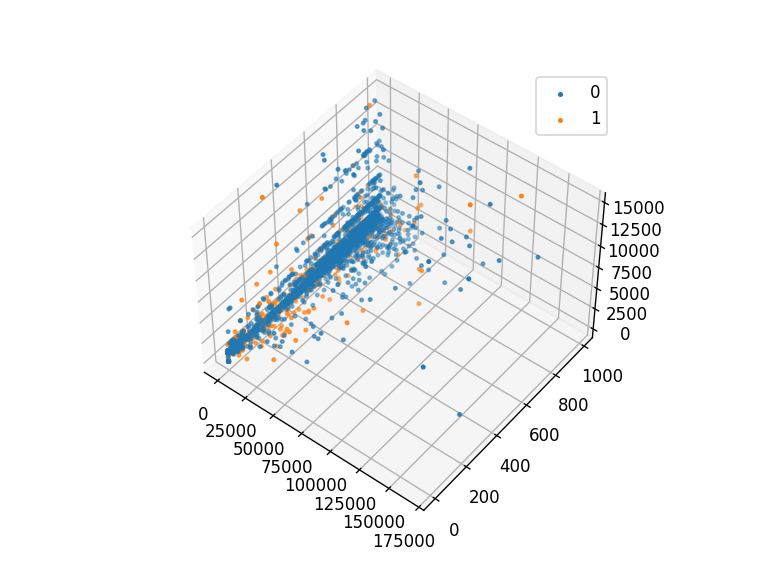

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(2):
    ax.scatter(train[train.target == i]['deuda_dir_vig_consu_mes00'], train[train.target == i]['risk_predictor_2'], train[train.target == i]['rango_ingresos_2'], label=i, s=4)
plt.legend()

<ipython-input-15-e3877dcb640d>:1: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  a3d = Axes3D(plt.figure(figsize=(9,5)))


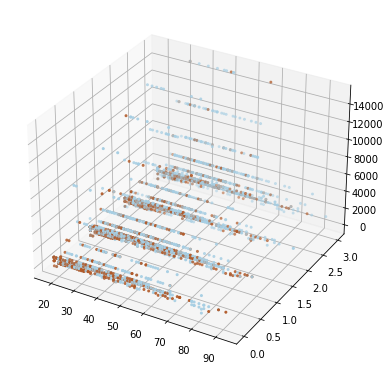

In [15]:
a3d = Axes3D(plt.figure(figsize=(9,5)))
a3d.scatter(train['edad'], train['direccion_eval'], train['rango_ingresos_2'], c=train.target, s=4, cmap=plt.cm.Paired)

### RamdomForest

In [13]:
inicio = time.time()
clf = RandomForestClassifier(random_state=42)
clf.fit(train[predictive_variables], train.target)
fin = time.time()
print(fin-inicio)
print("Train results:")
probabilities = model.predict_proba(train[predictive_variables])[:, 1]
roc_auc_score_by_threshold(probabilities, train.target)
print("Test results:")
probabilities = model.predict_proba(train[predictive_variables])[:, 1]
roc_auc_score_by_threshold(probabilities, test.target)

120.92232346534729
optimum threshold found: 0.34
roc value: 0.6347841106406159
 Confusion matrix: [[167465  90344]
 [ 50408  82244]]


### Choosing the probability threshold

In [ ]:
roc_auc_scores = []
for threshold in np.arange(0.01, 1, 0.01):
    predictions = probabilities >= threshold
    roc_auc_scores.append((threshold, roc_auc_score(testTmp.target, predictions)))
max_roc_auc_threshold = sorted(roc_auc_scores, key=lambda x:x[1], reverse=True)[0][0]
predictions = probabilities >= max_roc_auc_threshold
print(f'optimum threshold found: {max_roc_auc_threshold}')
print(roc_auc_score(testTmp.target, predictions))
print(confusion_matrix(test.target, predictions))

In [ ]:
categorical_cols = trainTmp.select_dtypes('O').columns
trainTmp = pd.get_dummies(trainTmp, columns=categorical_cols, drop_first=True)
trainTmp

In [ ]:
#1 Solo con varables no nulas y dummies
#optimum threshold found: 0.36000000000000004
#0.6230363896185201

#2 Solo con varables no nulas y aplicando direccion_eval 
#optimum threshold found: 0.36000000000000004
#0.6229165803362066

#3 Solo con varables no nulas y aplicando direccion_eval y dicc_reportado
#optimum threshold found: 0.36000000000000004
#0.6225590813571202

#4 Incluye rango_ingresos_2 a lo anterior
#optimum threshold found: 0.36000000000000004
#0.6226945635141578

#4 Incluye rcantidad_doc_morosos a lo anterior
# tiempo 360
#optimum threshold found: 0.34
#0.6261697339444241

### PCA

In [ ]:
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train[predictive_variables])

### Regrsión lineal

In [12]:
inicio = time.time()
clf = LogisticRegression()
clf.fit(train[predictive_variables], train.target)
probabilities = clf.predict_proba(train[predictive_variables])[:, 1]
fin = time.time()
print(fin-inicio)

roc_auc_score_by_threshold(probabilities, train.target)

3.3771140575408936
optimum threshold found: 0.34
roc value: 0.6118646305818197
 Confusion matrix: [[154901 102908]
 [ 50024  82628]]


### Kernel polinomico

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
inicio = time.time()
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(train[predictive_variables], train.target)
#probabilities = clf.predict_proba(test[predictive_variables])[:, 1]
sorted(clf.cv_results_.keys())
fin = time.time()
print(fin-inicio)

roc_auc_score_by_threshold(probabilities, test.target)

In [ ]:
param_grid_list = {'min_samples_split' : [100, 10000],
                  'min_samples_leaf' : [100, 10000],
                  'max_leaf_nodes' : [10, 1000],
                  'n_estimators' : [1, 2]}

for dicc in comb_dicc(param_grid_list):
    dicc_rfc = dicc.copy()
    print(dicc)
    rfc = RandomForestClassifier(random_state=42, **dicc_rfc)
    print("Train results:")
    show_metrics(rfc, train[predictive_variables], train.target)
    print("Test results:")
    show_metrics(rfc, test[predictive_variables], test.target)

## KNN

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 3, weigths = 'uniform')
clf.fit(train[predictive_variables], train.target)
clf.predict(test[predictive_variables])

## Grid of machine learning

In [26]:
machine_list = [LogisticRegression(), RandomForestClassifier(random_state=42)]
for clf in machine_list:
    inicio = time.time()
    clf.fit(train[predictive_variables], train.target)
    fin = time.time()
    print("Seconds of processing : ", (fin-inicio))
    print("Train results:")
    show_metrics(clf, train[predictive_variables], train.target)
    #probabilities = model.predict_proba(train[predictive_variables])[:, 1]
    #roc_auc_score_by_threshold(probabilities, train.target)
    print("Test results:")
    show_metrics(clf, test[predictive_variables], test.target)
    #probabilities = model.predict_proba(test[predictive_variables])[:, 1]
    #roc_auc_score_by_threshold(probabilities, test.target)
    print("------------------------")
    

Seconds of processing :  1.9911994934082031
Train results:
Confusion matrix: 
[[250762   7047]
 [122675   9977]]
{'precision': 0.5860549812030075, 'recall': 0.07521183246389047, 'f1': 0.13331462625938692, 'roc_auc': 0.6560322799170374}
Test results:
Confusion matrix: 
[[62667  1786]
 [30711  2452]]
{'precision': 0.5785747994336952, 'recall': 0.07393782227180895, 'f1': 0.13111948878372237, 'roc_auc': 0.6540308351749928}
------------------------
Seconds of processing :  108.55719780921936
Train results:
Confusion matrix: 
[[236469  21340]
 [ 98651  34001]]
{'precision': 0.6143907771814748, 'recall': 0.2563172813074812, 'f1': 0.3617262344874543, 'roc_auc': 0.6914281992959945}
Test results:
Confusion matrix: 
[[58106  6347]
 [25407  7756]]
{'precision': 0.5499539105154931, 'recall': 0.23387510177004492, 'f1': 0.32818516481191556, 'roc_auc': 0.6562120634821047}
------------------------


In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

model_svc = LinearSVC()
model = CalibratedClassifierCV(model_svc)
predictive_variables = ['direccion_eval', 'edad', 'rango_ingresos_2', 'cantidad_doc_morosos',
                        'ind_morosidad', 'clase_canal', 'canal', 'monto_doc_morosos_soles', 
                        'nivel_instruccion', 'estado_civil', 'risk_predictor_2', 'info_directorio_sunat' 
                        , 'cond_domicilio_sunat'] + columns_ent_deuda + columns_reportado + columns_calificacion + columns_deuda_dir_vig_consu

models = {}
models['Logistic Regression'] = {'model' : LogisticRegression, 'params' : {'random_state' : 42, 'max_iter' : 1500}}
models['Random Forest 13'] = {'model' : RandomForestClassifier, 'params' : {'random_state' : 42, 'max_depth' : 13}}
models['Decision Tree 8'] = {'model' : DecisionTreeClassifier, 'params' : {'random_state' : 42, 'max_depth' : 8}}
#models['GaussianNB'] = {'model' : GaussianNB, 'params' : {}}
#models['SVM'] = {'model' : LinearSVC, 'params' : {'random_state' : 42, 'max_iter' : 2500}}
models['Gradient Boosting'] = {'model' : GradientBoostingClassifier, 'params' : {'random_state' : 42, 'max_depth' : 4}}

performance = {}
scores = {}
for name, model_attributes in models.items():
    print(name)
    model_class = model_attributes['model']
    model = model_class(**model_attributes['params']).fit(X=train[predictive_variables], y=train['target'])
    #model = CalibratedClassifierCV(model_svc).fit(X=train[predictive_variables], y=train['target'])
    f1_score_train = f1_score(y_true=train['target'],
        y_pred=model.predict(train[predictive_variables]))
    f1_score_test = f1_score(y_true=test['target'],
        y_pred=model.predict(test[predictive_variables]))
    if name == 'SVM':
        roc_train = roc_auc_score(train.target, model.predict(train[predictive_variables]))
        roc_test = roc_auc_score(test.target, model.predict(test[predictive_variables]))
    else:
        roc_train = roc_auc_score(train.target, model.predict_proba(train[predictive_variables])[:,1])
        roc_test = roc_auc_score(test.target, model.predict_proba(test[predictive_variables])[:,1])
    scores[name] = [f1_score_train, f1_score_test, roc_train, roc_test]
    print(scores[name])
    
performance.update(scores)
performance = {k:v for k, v in sorted(performance.items(), key=lambda x: x[1], reverse=True)}
performance

Logistic Regression
{'Logistic Regression': [0.38115603413246646, 0.37936340811533165, 0.6978066216564145, 0.6956231518302503]}
Random Forest 13
{'Logistic Regression': [0.38115603413246646, 0.37936340811533165, 0.6978066216564145, 0.6956231518302503], 'Random Forest 13': [0.45032050488800895, 0.41369890131644066, 0.745128317708307, 0.7077769906042912]}
Decision Tree 8
{'Logistic Regression': [0.38115603413246646, 0.37936340811533165, 0.6978066216564145, 0.6956231518302503], 'Random Forest 13': [0.45032050488800895, 0.41369890131644066, 0.745128317708307, 0.7077769906042912], 'Decision Tree 8': [0.41806943202581354, 0.4136915715863084, 0.705753049937911, 0.6979486685659981]}
GaussianNB
{'Logistic Regression': [0.38115603413246646, 0.37936340811533165, 0.6978066216564145, 0.6956231518302503], 'Random Forest 13': [0.45032050488800895, 0.41369890131644066, 0.745128317708307, 0.7077769906042912], 'Decision Tree 8': [0.41806943202581354, 0.4136915715863084, 0.705753049937911, 0.697948668565

{'GaussianNB': [0.5229284781973254,
  0.5239482874257037,
  0.6533069818385665,
  0.652446732466379],
 'Random Forest 13': [0.45032050488800895,
  0.41369890131644066,
  0.745128317708307,
  0.7077769906042912],
 'Gradient Boosting': [0.43023883777616684,
  0.42705770683610017,
  0.7145054394066968,
  0.7101619308177579],
 'Decision Tree 8': [0.41806943202581354,
  0.4136915715863084,
  0.705753049937911,
  0.6979486685659981],
 'Logistic Regression': [0.38115603413246646,
  0.37936340811533165,
  0.6978066216564145,
  0.6956231518302503]}

## Metodhs

### Graphs of barras by value

In [ ]:
printBarrasApiladas(df, 'codigo_rubro_actividad', normalize=True)

### Null Relation

In [ ]:
deudaList = filter_columns(df, 'rubro_actividad')
deudaList = ['situacion_contribuyente','tipo_sociedad' ]
notNullRelation(df , deudaList)

### Count Values

In [ ]:
filter_col = filter_columns(df, 'cant_ent_deuda_consu')
print(filter_col)

In [ ]:
pca = PCA(n_components=2)
X_MNIST_PCA = pca.fit_transform(testTmp[predictive_variables])
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
for i in range(2):
    ax.scatter(X_MNIST_PCA[testTmp.target == i,0], X_MNIST_PCA[testTmp.target == i,1], label=i, s=4)
    #ax.plot_wireframe(X_MNIST_PCA[testTmp.target == i,0], X_MNIST_PCA[testTmp.target == i,1], X_MNIST_PCA[testTmp.target == i,2], label=i, s=4)
plt.legend()

In [21]:
df["cant_ent_deuda_consu_mes00"].value_counts()

-1.0    238796
 0.0     85835
 1.0     84851
 2.0     42726
 3.0     21539
 4.0      9500
 5.0      3525
 6.0      1027
 7.0       224
 8.0        48
 9.0         6
Name: cant_ent_deuda_consu_mes00, dtype: int64

In [ ]:
gammaList = [0.1, 1, 5]
kernelList = ["linear", "poly", "rbf", "sigmoid", "cosine"]

fig, axis = plt.subplots(len(gammaList), len(kernelList), figsize=(16, 6))
for idg, gamma in  enumerate(gammaList):
    gammaCal = gamma/test.shape[1]
    for idk, kernel in enumerate(kernelList):
        pcak = KernelPCA(n_components=2, gamma = gammaCal, kernel = kernel)
        dataCal = pcak.fit_transform(test[predictive_variables])
        axis[idg][idk].scatter(dataCal[:,0], dataCal[:,1], c=test.target, s=2, cmap='jet')
        axis[idg][idk].set_title('Dataset {} {} {}'.format("Data", kernel, gamma))
plt.tight_layout()

In [54]:
df_tmp = df[["target", "nivel_instruccion"]]
df_tmp = df_tmp.groupby("nivel_instruccion").target.agg(['mean', 'sum', 'count'])
df_tmp['mean']

from sklearn.cluster import KMeans
model = KMeans(n_clusters = 4)
model.fit(df_tmp['mean'].values.reshape(-1, 1))
dicc_labels = dict(zip(model.cluster_centers_[:,0], list(range(4))))
labels_sort = dict(sorted(dicc_labels.items(), key=lambda item: item[0])).values()
dicc_sort = dict(zip(labels_sort, list(range(4))))
df_tmp['group'] = np.vectorize(dicc_sort.get)(model.labels_)
dicc_nivel_instruccion = dict(zip(df_tmp.index, df_tmp['group']))
dicc_nivel_instruccion

[0.52919708 0.17037344 0.1875     0.40625    0.18041804 0.14007782
 0.0972973  0.46749358 0.27272727 0.22836245 0.2        0.40769177
 0.51533041 0.3512802  0.46723691 0.22917618 0.22448403 0.16561694
 0.25706472 0.27743203]


{'Analfabeto / Iletrado': 3,
 'Bachiller': 0,
 'Doctorado': 0,
 'Educación Especial': 2,
 'FFAA y Policiales': 0,
 'Licenciado': 0,
 'Maestría': 0,
 'No Identificado': 3,
 'No dio información': 1,
 'No identificado': 1,
 'No informado': 0,
 'Primaria Completa': 2,
 'Primaria Incompleta': 3,
 'Secundaria Completa': 2,
 'Secundaria Incompleta': 3,
 'Superior Completa': 1,
 'Superior Incompleta': 1,
 'Titulado': 0,
 'Técnica Completa': 1,
 'Técnica Incompleta': 1}

In [49]:
dicc_labels = dict(zip(model.cluster_centers_[:,0], list(range(4))))
labels_sort = dict(sorted(dicc_labels.items(), key=lambda item: item[0])).values()
dicc_sort = dict(zip(labels_sort, list(range(4))))
dicc_sort

{2: 0, 0: 1, 3: 2, 1: 3}

In [67]:
df['nivel_instruccion']

0         4
1         4
2         6
3         4
4         6
         ..
488072    2
488073    2
488074    4
488075    4
488076    4
Name: nivel_instruccion, Length: 488077, dtype: int64